<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202402/blob/main/Lecture08/Notebook_Classification_ClassImbalance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification

To work through the steps of probability-based classification, we’ll use a real dataset on unemployment from the Argentine Permanent Household Survey (EPH). This dataset includes socio-economic and demographic variables that allow us to predict whether a person is unemployed or not.

Unemployment prediction is a classic problem of classification and remains one of the key application areas for machine learning: we use previous employment results (employed versus unemployed) to train a model that can predict the employment status of individuals in new cases.

\begin{align}
Unemployment = f(x) + u
\end{align}

where $Unemployment = I(Unemployment=1)$


In [ ]:
# install.packages("pacman") #run this line if you use Google Colab

In [ ]:
#Cargar librerías 
require("pacman")
p_load("tidyverse", "caret", "glmnet","MLeval","MLmetrics")
set.seed(1011)

In [ ]:
#Leer los datos 
db <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/desempelo_arg_2010.Rds?raw=true"))
db <- db %>% filter(ciudad%in%c("Partidos del GBA", "Ciudad de Buenos Aires"))
head(db)

In [ ]:
table(db$nivel_ed)

In [ ]:
#db <- db %>% filter(nivel_ed!="Ns./Nr.")
db$nivel_ed <- droplevels(db$nivel_ed)
table(db$nivel_ed)

In [ ]:
db$tipo_vivienda <- droplevels(db$tipo_vivienda)
db$parentesco <- droplevels(db$parentesco)

In [ ]:
table(db$tipo_vivienda)

In [ ]:
db <- db %>% mutate(tipo_vivienda=recode(tipo_vivienda,
                                         "Pieza de inquilino"="Otros",
                                         "Pieza en hotel/pension"="Otros",
                                         "Local no construido para habitacion"="Otros"))
table(db$tipo_vivienda)                  

In [ ]:
db <- db %>% mutate(mujer=factor(mujer,levels=c(0,1),labels=c("hombre","mujer")))
head(db)

In [ ]:
prop.table(table(db$desempleado))*100

In [ ]:
data<- db  %>% group_by(desempleado) %>% tally() 
data <- data %>% mutate(n=n/sum(n))                        

In [ ]:
data<-  data %>% mutate(estado =factor(desempleado, levels = c(0,1), labels = c("empleado","desempleado")) )

ggplot(data,aes(x = estado, y = n, fill = estado)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + # Colors can be changed
  labs(x = "", y = "count") # Customize axis labels if needed



If you have an imbalanced data set, first try training on the true distribution. If the model works well and generalizes, you're done! If not, try  the remedies listed below.

## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [ ]:
mylogit <- glm(desempleado~edad+mujer, data = db, family = "binomial")
summary(mylogit,type="text")

## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [ ]:

db<- db  %>% mutate(prob_hat=predict(mylogit,newdata = db, type = "response")) #type = "response" gives the predicted probabilities.

head(db  %>% select(desempleado,prob_hat))


## Classification 

\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [ ]:
rule <- 1/2 # Bayes Rule

db <-  db  %>% mutate(desempleado_hat=ifelse(prob_hat>rule,1,0))    ## predicted class labels

head(db  %>% select(desempleado,prob_hat,desempleado_hat))


## Out of sample prediction

In [ ]:
p_load("caret")


inTrain <- createDataPartition(
  y = db$desempleado, ## La variable dependiente u objetivo 
  p = .7,  ## Usamos 70%  de los datos en el conjunto de entrenamiento 
  list = FALSE)


train <- db[ inTrain,]
test  <- db[-inTrain,]

In [ ]:
head(train)

In [ ]:
prop.table(table(train$desempleado))

In [ ]:
prop.table(table(test$desempleado))

### Logit

In [ ]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)


In [ ]:
# train<- train %>% mutate(desempleado_num =desempleado)

# # Clace que "desempleado" sea el primer nivel!!
# train<- train %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))
# test<- test %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))


In [ ]:
prop.table(table(train$desempleado))

In [ ]:
set.seed(1410)
mylogit_caret <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")


mylogit_caret

In [ ]:
predictTest_logit <- data.frame(
  obs = test$desempleado,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [ ]:
head(predictTest_logit)

In [ ]:
test<- test  %>% mutate(desempleo_hat_logit_orig=predict(mylogit_caret,newdata = test,
                           type = "raw"))

In [ ]:
confusionMatrix(data = test$desempleo_hat_logit_orig, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


In [ ]:
X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda",
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


set.seed(1410)
glm_model_logit_ampliado <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = train,
    family = "binomial",
    trControl = ctrl,
    preProcess = c("center", "scale")
  )



test<- test  %>% mutate(desempleo_hat_logit_ampliado=predict(glm_model_logit_ampliado,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


# ROC

In [ ]:
#Curva ROC
res_insample_all <- evalm(list(mylogit_caret, glm_model_logit_ampliado),gnames=c('Basic','Ampliado'),plots='r')

In [ ]:
X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE)", #cambio
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


lambda <- 10^seq(-1, -4, length = 50)
grid <- expand.grid("alpha" = seq(0,1,by=.1), lambda = lambda)

set.seed(1410)
glm_model_en <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    trControl = ctrl,
    tuneGrid = grid,
    preProcess = c("center", "scale")
  )

glm_model_en



In [ ]:
test<- test  %>% mutate(desempleo_hat_logit_en=predict(glm_model_en,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_en, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

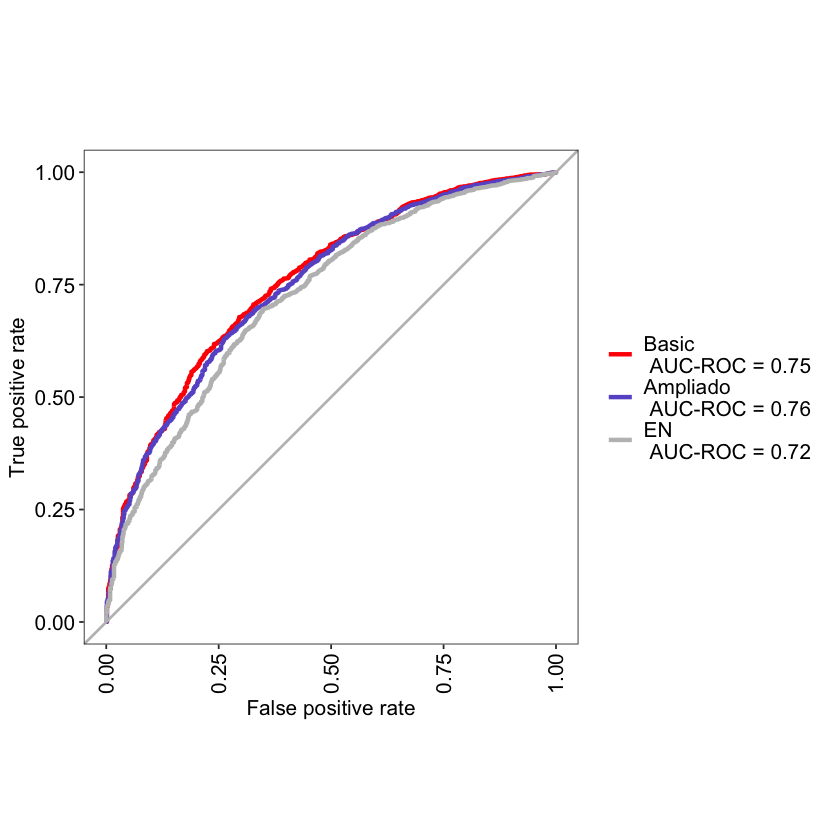

In [ ]:
#Curva ROC
res_insample_all <- evalm(list(mylogit_caret, glm_model_logit_ampliado,glm_model_en),gnames=c('Basic','Ampliado','EN'),plots='r')

# Class Imbalance: Remedies

In [ ]:

ggplot(data,aes(x = estado, y = n, fill = estado)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + # Colors can be changed
  labs(x = "", y = "count") # Customize axis labels if needed



## Model Tuning

The simplest approach to counteracting the negative eﬀects of class imbalance is to tune the model to maximize the accuracy of the minority class(es).

In [ ]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))

ctrl_multiStats<- trainControl(method = "cv",
                     number = 5,
                     summaryFunction = multiStats,
                     classProbs = TRUE,
                     verbose=FALSE,
                     savePredictions = T)

In [ ]:

X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE)", #cambio
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


lambda <- 10^seq(-1, -4, length = 50)
grid <- expand.grid("alpha" = seq(0,1,by=.2), lambda = lambda)

set.seed(1410)
glm_model_en_sens <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    tuneGrid = grid,
    preProcess = c("center", "scale"),
    trControl = ctrl_multiStats,
    metric = "Sens"
  )

glm_model_en_sens

In [ ]:
test<- test  %>% mutate(desempleo_hat_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_en_sens, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

## Alternative Cutoﬀs

When there are two possible outcome categories, another method for increasing the prediction accuracy of the minority class samples is to determine alternative cutoﬀs for the predicted probabilities which eﬀectively changes the definition of a predicted event.

In [ ]:
p_load("pROC")

roc_obj_en<-roc(response=glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda],
                   predictor=glm_model_en_sens$pred$desempleado[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda],
                  levels = c("empleado", "desempleado"),  # Establecer control y caso
                  direction = "<")  # "<" significa que "desempleado" es positivo

In [ ]:
rfThresh_en <- coords(roc_obj_en, x = "best", best.method = "closest.topleft")
rfThresh_en

In [ ]:

test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "prob")$desempleado)
head(test)

In [ ]:

test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff=factor(ifelse(desempleo_prob_logit_en_sens>=rfThresh_en$threshold,1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))
         
confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

## Precision Recall Curve

In [ ]:
prec_recall<-data.frame(coords(roc_obj_en, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))
prec_recall

In [ ]:
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

In [ ]:
prec_recall$threshold[which.max(prec_recall$F1)]

In [ ]:
test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "prob")$desempleado)

test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff_F1=factor(ifelse(desempleo_prob_logit_en_sens>=prec_recall$threshold[which.max(prec_recall$F1)],1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))
         
confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff_F1, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

## Remuestreo

Hay varios enfoques:

  1. Up-sampling.  Simulates or imputes additional data points of the minority class to improve balance across classes, while 
  2. Down-sampling. Randomly reduces the number of the majority class  to improve the balance across classes.
  3. Híbrido: SMOTE, ROSE

<div >
<img src = "sampling_methods.png" />
</div>

### Down Sampling


In [ ]:
set.seed(1103)
downSampledTrain <- downSample(x = train,
                           y = train$desempleado,
                           ## keep the class variable name the same:
                           yname = "desempleado")
dim(train)


dim(downSampledTrain)

table(downSampledTrain$desempleado)



In [ ]:


X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda",
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


set.seed(1410)
glm_model_logit_ampliado_downsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = downSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,
    preProcess = c("center", "scale")
  )

glm_model_logit_ampliado_downsample

In [ ]:
options(warn=-1)

test<- test  %>% mutate(desempleo_hat_logit_ampliado_downsample=predict(glm_model_logit_ampliado_downsample,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado_downsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


### Up Sampling

In [ ]:
set.seed(1103)
upSampledTrain <- upSample(x = train,
                           y = train$desempleado,
                           yname = "desempleado")
dim(train)

dim(upSampledTrain)

table(upSampledTrain$desempleado)


In [ ]:
set.seed(1410)
glm_model_logit_ampliado_upsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = upSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,
    preProcess = c("center", "scale")
  )

glm_model_logit_ampliado_upsample


In [ ]:

test<- test  %>% mutate(desempleo_hat_logit_ampliado_upsample=predict(glm_model_logit_ampliado_upsample,newdata = test,
                           type = "raw"))
confusionMatrix(data = test$desempleo_hat_logit_ampliado_upsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")


### SMOTE

El synthetic minority over-sampling technique (SMOTE) (Chawla et al., 2002), utiliza tanto muestreo hacia arriba (up-sampling) como hacia abajo (down-sampling)

- Para mejorar la muestra de la clase minoritaria, SMOTE sintetiza nuevos casos. Para ello, se selecciona aleatoriamente un punto de datos de la clase minoritaria y se determinan sus K vecinos más cercanos (KNN). El nuevo punto de datos sintético es una combinación convexa aleatoria de los predictores del punto de datos seleccionado al azar y sus vecinos.

- Si bien el algoritmo SMOTE agrega nuevas muestras a la clase minoritaria a través de un muestreo ascendente, también puede reducir la muestra de casos de la clase mayoritaria a través de un muestreo aleatorio para ayudar a equilibrar el conjunto de entrenamiento.

<div >
<img src = "smote.png" />
</div>

In [ ]:
p_load("smotefamily")

predictors<-colnames(train  %>% select(edad,mujer,nivel_ed,parentesco, estado_civil,tipo_vivienda,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam))
head( train[predictors])


In [ ]:
smote_output <- SMOTE(X = train[predictors],
                     target = train$desempleado,
                     K=5)
smote_data <- smote_output$data


In [ ]:
# Convertir la fórmula en una matriz de diseño 
X_train <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) + nivel_ed + mujer + parentesco + estado_civil + tipo_vivienda + poly(total_miembros_hogar,2,raw=TRUE) + poly(miembros_hogar_menores10,2,raw=TRUE) + poly(ing_tot_fam,2,raw=TRUE), train)

# Eliminar la primera columna que es el intercepto (opcional)
X_train <- X_train[, -1]
head(X_train)

In [ ]:
colnames(X_train)<-paste0("X",seq(1,30))
colnames(X_train)
X_train<-data.frame(X_train)

In [ ]:
smote_data <- SMOTE(X = X_train, target = train$desempleado, K = 5)

In [ ]:
table(train$desempleado)


In [ ]:
head(smote_data$data)

In [ ]:
str(smote_data$data$class)

In [ ]:
set.seed(1410)

desempleado_logit_smote <- train(class ~.,
                       data = smote_data$data, 
                       method = "glm",
                      family = "binomial",
                        trControl = ctrl_multiStats,
                        preProcess = c("center", "scale")
                      )

desempleado_logit_smote



In [ ]:
test<- test  %>% mutate(desempleado_hat_smote_orig=predict(desempleado_logit_smote,newdata = test,
                         type = "raw"))

In [ ]:
X_test <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) + nivel_ed + mujer + parentesco + estado_civil + tipo_vivienda + poly(total_miembros_hogar,2,raw=TRUE) + poly(miembros_hogar_menores10,2,raw=TRUE) + poly(ing_tot_fam,2,raw=TRUE), test)
X_test <- X_test[, -1]
colnames(X_test)<-paste0("X",seq(1,30))
colnames(X_test)
X_test<-data.frame(X_test)

In [ ]:
test<- test  %>% mutate(desempleado_hat_smote_orig=predict(desempleado_logit_smote,newdata = X_test,
                           type = "raw"))

In [ ]:
confusionMatrix(data = test$desempleado_hat_smote_orig, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")